In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, scale
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [24]:
#Unpickle file for modeling
df = pd.read_pickle("./modeling_df.pkl")

In [21]:
df.head()

,hotel_name,rating,walk_score,res_score,attraction_score,num_reviews,num_QA,num_Tips,num_rooms,min_price,max_price,avg_price,walk_perfect
19,30 Bencoolen,4.5,100,352,58,545,53,53,131,186.0,379.0,282.5,1
6,5footway.inn Project Ann Siang,3.5,100,941,129,235,15,15,26,31.0,158.0,94.5,1
44,7 Wonders Hostel,3.5,97,302,18,133,9,9,9,30.0,302.0,166.0,0
54,7 Wonders Hostel At Upper Dickson,4.5,100,248,44,4,1,1,75,23.0,212.0,117.5,1
13,@ Little Red Dot,4.0,90,135,12,458,5,5,18,18.0,61.0,39.5,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 19 to 39
Data columns (total 13 columns):
hotel_name          292 non-null object
rating              292 non-null float64
walk_score          292 non-null int64
res_score           292 non-null int64
attraction_score    292 non-null int64
num_reviews         292 non-null int64
num_QA              292 non-null int64
num_Tips            292 non-null int64
num_rooms           292 non-null int64
min_price           292 non-null float64
max_price           292 non-null float64
avg_price           292 non-null float64
walk_perfect        292 non-null uint8
dtypes: float64(4), int64(7), object(1), uint8(1)
memory usage: 29.9+ KB


## diagnostic plots

In [25]:
data = df[['res_score', 'attraction_score','num_reviews','num_QA','num_Tips','max_price','num_rooms','num_reviews', 'walk_perfect', 'min_price','max_price','avg_price']] #'walk_score', 'res_score', 'attraction_score','num_reviews', 'num_QA', 'num_Tips', 'num_rooms', 'min_price','max_price', 'avg_price

target = df['rating'] 

X, y = data, target

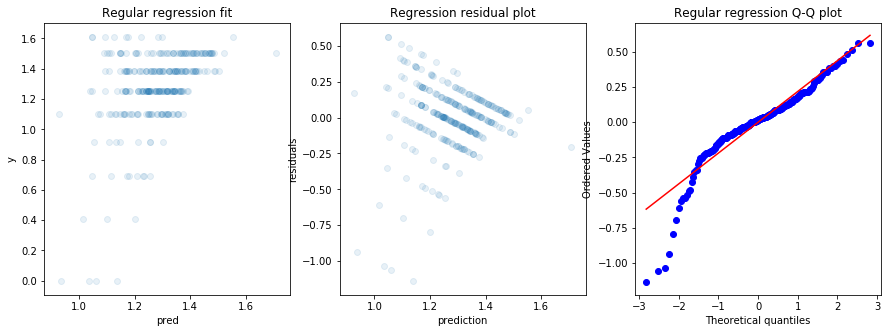

In [16]:
#Diagnostic plots
plt.figure(figsize=(15,5))



rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

In [26]:
#diagnostic plots don't look like a good fit. use box-cox transformation to make data more linear. 
#walk_perfect not transformed since it's dummy
transform = np.asarray(df[['max_price']].values)
max_price_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['res_score']].values)
res_score_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['attraction_score']].values)
attraction_score_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['num_reviews']].values)
num_reviews_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['num_rooms']].values)
num_rooms_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['num_QA']].values)
num_QA_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['num_Tips']].values)
num_Tips_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['min_price']].values)
min_price_t = stats.boxcox(transform)[0]
transform = np.asarray(df[['avg_price']].values)
avg_price_t = stats.boxcox(transform)[0]

In [27]:
df['max_price'] = max_price_t
df['res_score'] = res_score_t
df['attraction_score'] = attraction_score_t
df['num_reviews'] = num_reviews_t
df['num_rooms'] = num_rooms_t
df['num_QA'] = num_QA_t
df['num_Tips'] = num_Tips_t
df['min_price'] = min_price_t
df['avg_price'] = avg_price_t

In [28]:
#also transforming the rating variable
transform = np.asarray(df[['rating']].values)
rating_t = stats.boxcox(transform)[0]
df['rating'] = rating_t

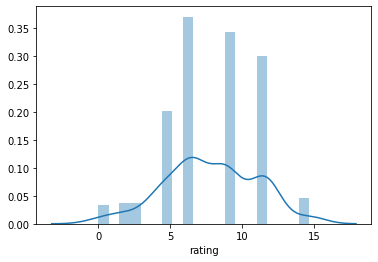

In [59]:
#rating after boxcox transformation - to move to EDA
sns.distplot(df.rating, bins=20);

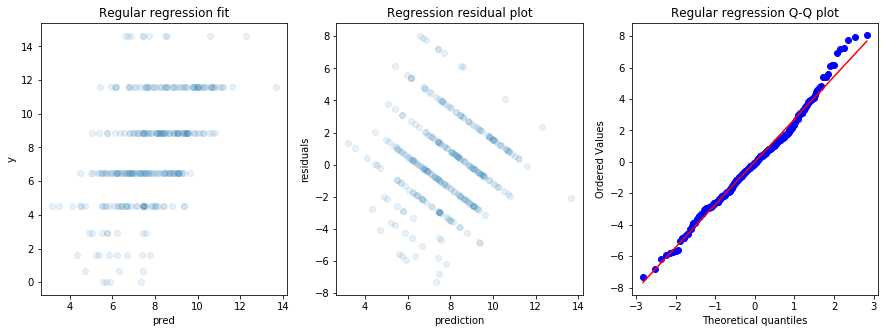

In [77]:
#Diagnostic plots 2nd try
#after boxcox transformation
data = df[['res_score', 'attraction_score','num_reviews','num_QA','num_Tips','max_price','num_rooms','num_reviews', 'walk_perfect', 'min_price','max_price','avg_price']] #'walk_score', 'res_score', 'attraction_score','num_reviews', 'num_QA', 'num_Tips', 'num_rooms', 'min_price','max_price', 'avg_price

target = df['rating'] 
plt.figure(figsize=(15,5))

X, y = data, target

rgr = LinearRegression()
rgr.fit(X, y)
pred = rgr.predict(X)

plt.subplot(1, 3, 1)
plt.scatter(pred, y, alpha = 0.1)
plt.title("Regular regression fit")
plt.xlabel("pred")
plt.ylabel("y")

plt.subplot(1, 3, 2)
res = (y - pred)
plt.scatter(pred, res, alpha = 0.1)
plt.title("Regression residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

plt.subplot(1, 3, 3)
pred = rgr.predict(X)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Regular regression Q-Q plot");

#### QQ plot is a better fit but the other two suggest regression is perhaps not the best model. Will proceed for now

### Baselining with OLS

In [29]:
#1st model R^2 0.271, Adj. R-squared: 0.248
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('rating ~ res_score + attraction_score + num_reviews + num_QA + num_Tips + max_price + num_rooms + num_reviews + walk_perfect + min_price + max_price + avg_price', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()
# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     11.65
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           1.46e-15
Time:                        16:54:47   Log-Likelihood:                -705.27
No. Observations:                 292   AIC:                             1431.
Df Residuals:                     282   BIC:                             1467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -20.5098      7.125     -2.878      0.004     -34.535      -6.484
res_score            0.1334      0.123      1.084      0.279      -0.109       0.376
attraction_score     0.3095      0.193      1.603      0.110      -0.071       0.690
num_reviews         -0.2057      0.110     -1.864      0.063      -0.423       0.011
num_QA               0.4201      0.126      3.345      0.001       0.173       0.667
num_Tips             0.4201      0.126      3.345      0.001       0.173       0.667
max_price           39.2176     17.400      2.254      0.025       4.967      73.468
num_rooms           -0.3671      0.119     -3.085      0.002      -0.601      -0.133
walk_perfect        -1.2758      0.605     -2.109      0.036      -2.467      -0.085
min_price            1.8994      0.655      2.900      0.004       0.610       3.189
avg_price          -30.7706     15.472     -1.989      0.048     -61.225      -0.316
==============================================================================
Omnibus:                        6.398   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.356
Skew:                           0.290   Prob(JB):                       0.0417
Kurtosis:                       3.431   Cond. No.                     9.19e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
#2nd model - dropping highest p-values res_score
lm2 = smf.ols('rating ~ res_score + attraction_score + walk_score + num_reviews + num_QA+num_Tips + max_price + num_rooms + num_reviews + min_price + max_price + avg_price', data=df)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     10.99
Date:                Mon, 08 Jun 2020   Prob (F-statistic):           1.13e-14
Time:                        16:54:50   Log-Likelihood:                -707.55
No. Observations:                 292   AIC:                             1435.
Df Residuals:                     282   BIC:                             1472.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -18.7593      7.170     -2.616      0.009     -32.873      -4.645
res_score            0.0815      0.129      0.634      0.527      -0.172       0.334
attraction_score     0.1312      0.179      0.733      0.464      -0.221       0.483
walk_score           0.0028      0.021      0.135      0.893      -0.038       0.043
num_reviews         -0.2179      0.111     -1.962      0.051      -0.436       0.001
num_QA               0.4407      0.127      3.471      0.001       0.191       0.691
num_Tips             0.4407      0.127      3.471      0.001       0.191       0.691
max_price           35.8389     17.506      2.047      0.042       1.379      70.299
num_rooms           -0.3758      0.120     -3.131      0.002      -0.612      -0.139
min_price            1.7495      0.656      2.665      0.008       0.457       3.041
avg_price          -27.7211     15.561     -1.781      0.076     -58.352       2.909
==============================================================================
Omnibus:                        5.332   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                5.148
Skew:                           0.265   Prob(JB):                       0.0762
Kurtosis:                       3.378   Cond. No.                     1.95e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.68e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [7]:
### both R^2 and adjusted R^2 dropped so first model is better

### train/test/split

In [31]:
#first split 20%
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X,y,test_size=0.2, random_state = 42)

In [32]:
#second split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

### modeling using sklearn

In [33]:
#modeling using sklearn
lr_model_1 = LinearRegression()
lr_model_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
lr_model_1.coef_

array([[  0.        ,   0.1611942 ,   0.11235446,  -0.25008957,
          0.45342215,   0.45342215,  34.37642229,  -0.30962154,
         -0.41699443,   1.7324678 , -26.21485892]])

In [35]:
#R^2 on validation set
lr_model_1.score(X_val, y_val)

0.12904038571958776

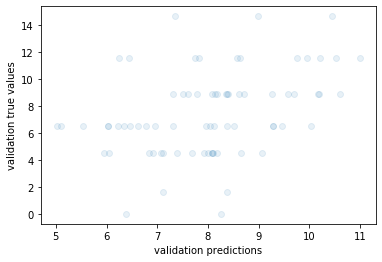

In [14]:
plt.scatter(lr_model_1.predict(X_val), y_val, alpha=.1)
plt.plot(np.linspace(0,12,0.1),np.linspace(0,12,0.1))
plt.xlabel("validation predictions")
plt.ylabel("validation true values");

In [18]:
#Perform cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

X_cv, y_cv = np.array(X), np.array(y)

cv_lm_r2s = []
#cv_lm_rmse = []

for train_ind, val_ind in kf.split(X_cv, y_cv):
    
    X_cv_train, y_cv_train = X_cv[train_ind], y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], y_cv[val_ind] 
    
    lr_model_1.fit(X_cv_train, y_cv_train)
    
    cv_lm_r2s.append(lr_model_1.score(X_val, y_val))
    #cv_lm_rmse.append(RMSE(y_val, lr_model_1.predict(X_val)))

#Check RMSE and r^2 for cross-validation.   
print('Basic Linear Regression mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
#print('Basic Linear Regression mean cv RMSE: %.3f +- %.3f' %(np.mean(cv_lm_rmse),np.std(cv_lm_rmse)))

Basic Linear Regression mean cv r^2: 0.140 +- 0.103


In [36]:
a = lr_model_1.predict(X_test)

In [37]:
a[4]

array([5.40033835])

In [38]:
y_test

,rating
15,8.849575
24,6.509677
0,11.557545
15,11.557545
22,1.611256
10,8.849575
18,11.557545
40,8.849575
4,8.849575
17,6.509677


In [39]:
#mean squared error MSE
np.mean((a-y_test)**2)

rating    6.182327
dtype: float64

In [40]:
#RMSE
np.sqrt(np.mean((a-y_test)**2))

rating    2.486429
dtype: float64

In [41]:
#set up the 3 models to compare:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [42]:
#validate #3 models

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.129
Ridge Regression val R^2: 0.117
Degree 2 polynomial regression val R^2: -0.013


In [43]:
#cross validation
from sklearn.model_selection import KFold

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [44]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.27078298510694876, 0.2154398873834592, 0.10496714546360564, 0.16196912115870432, 0.25528647508134306]
Ridge scores:  [0.3097694971933813, 0.20429173931924327, 0.09393600594411777, 0.1740000469310523, 0.23220481167439078] 

Simple mean cv r^2: 0.202 +- 0.061
Ridge mean cv r^2: 0.203 +- 0.071


In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.117


### Ridge Regression

In [47]:
y = df.rating
X_= df.drop(['rating','walk_perfect', 'hotel_name'], axis = 1)
X = pd.concat([X_, df[['walk_perfect']]], axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 19 to 39
Data columns (total 11 columns):
walk_score          292 non-null int64
res_score           292 non-null float64
attraction_score    292 non-null float64
num_reviews         292 non-null float64
num_QA              292 non-null float64
num_Tips            292 non-null float64
num_rooms           292 non-null float64
min_price           292 non-null float64
max_price           292 non-null float64
avg_price           292 non-null float64
walk_perfect        292 non-null uint8
dtypes: float64(9), int64(1), uint8(1)
memory usage: 25.4 KB


In [48]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [49]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 11)

Text(0, 0.5, 'weights')

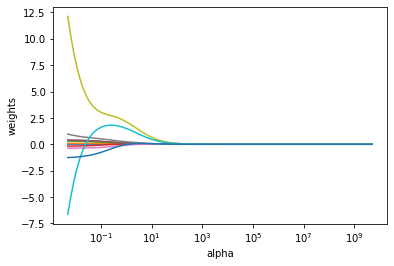

In [50]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [51]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [52]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))

walk_score          0.002794
res_score           0.006124
attraction_score    0.022002
num_reviews         0.019568
num_QA              0.061269
num_Tips            0.061269
num_rooms          -0.016480
min_price           0.124354
max_price           1.065395
avg_price           0.749216
walk_perfect       -0.010755
dtype: float64
8.374740444868007


In [53]:
#using CV to choose alpha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.24885117821660568

In [54]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

7.476898240155887

In [55]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)

walk_score          0.011646
res_score           0.080887
attraction_score    0.149102
num_reviews        -0.031429
num_QA              0.207468
num_Tips            0.207468
num_rooms          -0.225818
min_price           0.396166
max_price           2.721462
avg_price           1.809626
walk_perfect       -0.439398
dtype: float64

In [56]:
#RMSE
np.sqrt(mean_squared_error(y_test, ridge4.predict(X_test)))

2.5412360104742198